# 1 Dependency import

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

***
# 2 Data loading

In [19]:
data = pd.read_csv("data/2015-building-energy-benchmarking.csv", delimiter=",")

***
# 3 Overview

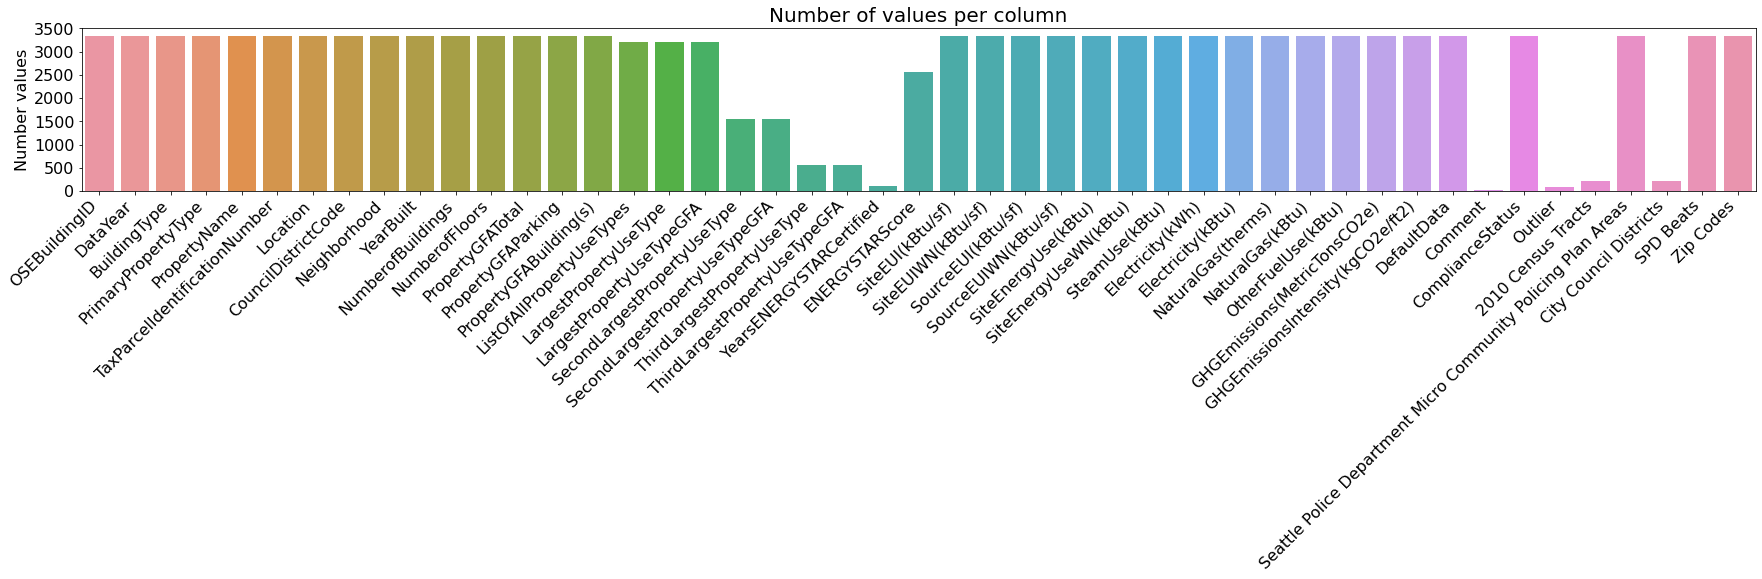

In [20]:
plt.figure(figsize=(30, 3))

sns.barplot(x=data.columns, y=data.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [21]:
data.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,...,NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,...,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,...,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,...,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,...,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,...,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,...,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000


In [22]:
data.describe(include="object")

,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,Comment,ComplianceStatus,Outlier
count,3340,3340,3340,3338,3340,3340,3213,3204,1559,560,110,3339,13,3340,84
unique,7,27,3287,3245,3298,13,442,56,47,41,61,2,13,2,2
top,NonResidential,Low-Rise Multifamily,WAREHOUSE,925049346,"{'latitude': '47.52593209', 'longitude': '-122...",DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,No,Under construction starting 6/2013 (old buildi...,Compliant,High Outlier
freq,1461,998,9,5,5,578,862,1598,881,107,20,2791,1,3337,46


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [24]:
data["SiteEnergyUse(kBtu)"].loc[data["SiteEnergyUse(kBtu)"].isna()]

62     NaN
719    NaN
767    NaN
1346   NaN
1358   NaN
1360   NaN
1838   NaN
2108   NaN
2381   NaN
2406   NaN
Name: SiteEnergyUse(kBtu), dtype: float64

In [25]:
data.dropna(subset=["SiteEnergyUse(kBtu)"], inplace=True)

In [35]:
data["SiteEnergyUse(kBtu)"].loc[data["SiteEnergyUse(kBtu)"].isna()]

Series([], Name: SiteEnergyUse(kBtu), dtype: float64)

***
# 4 Correlations

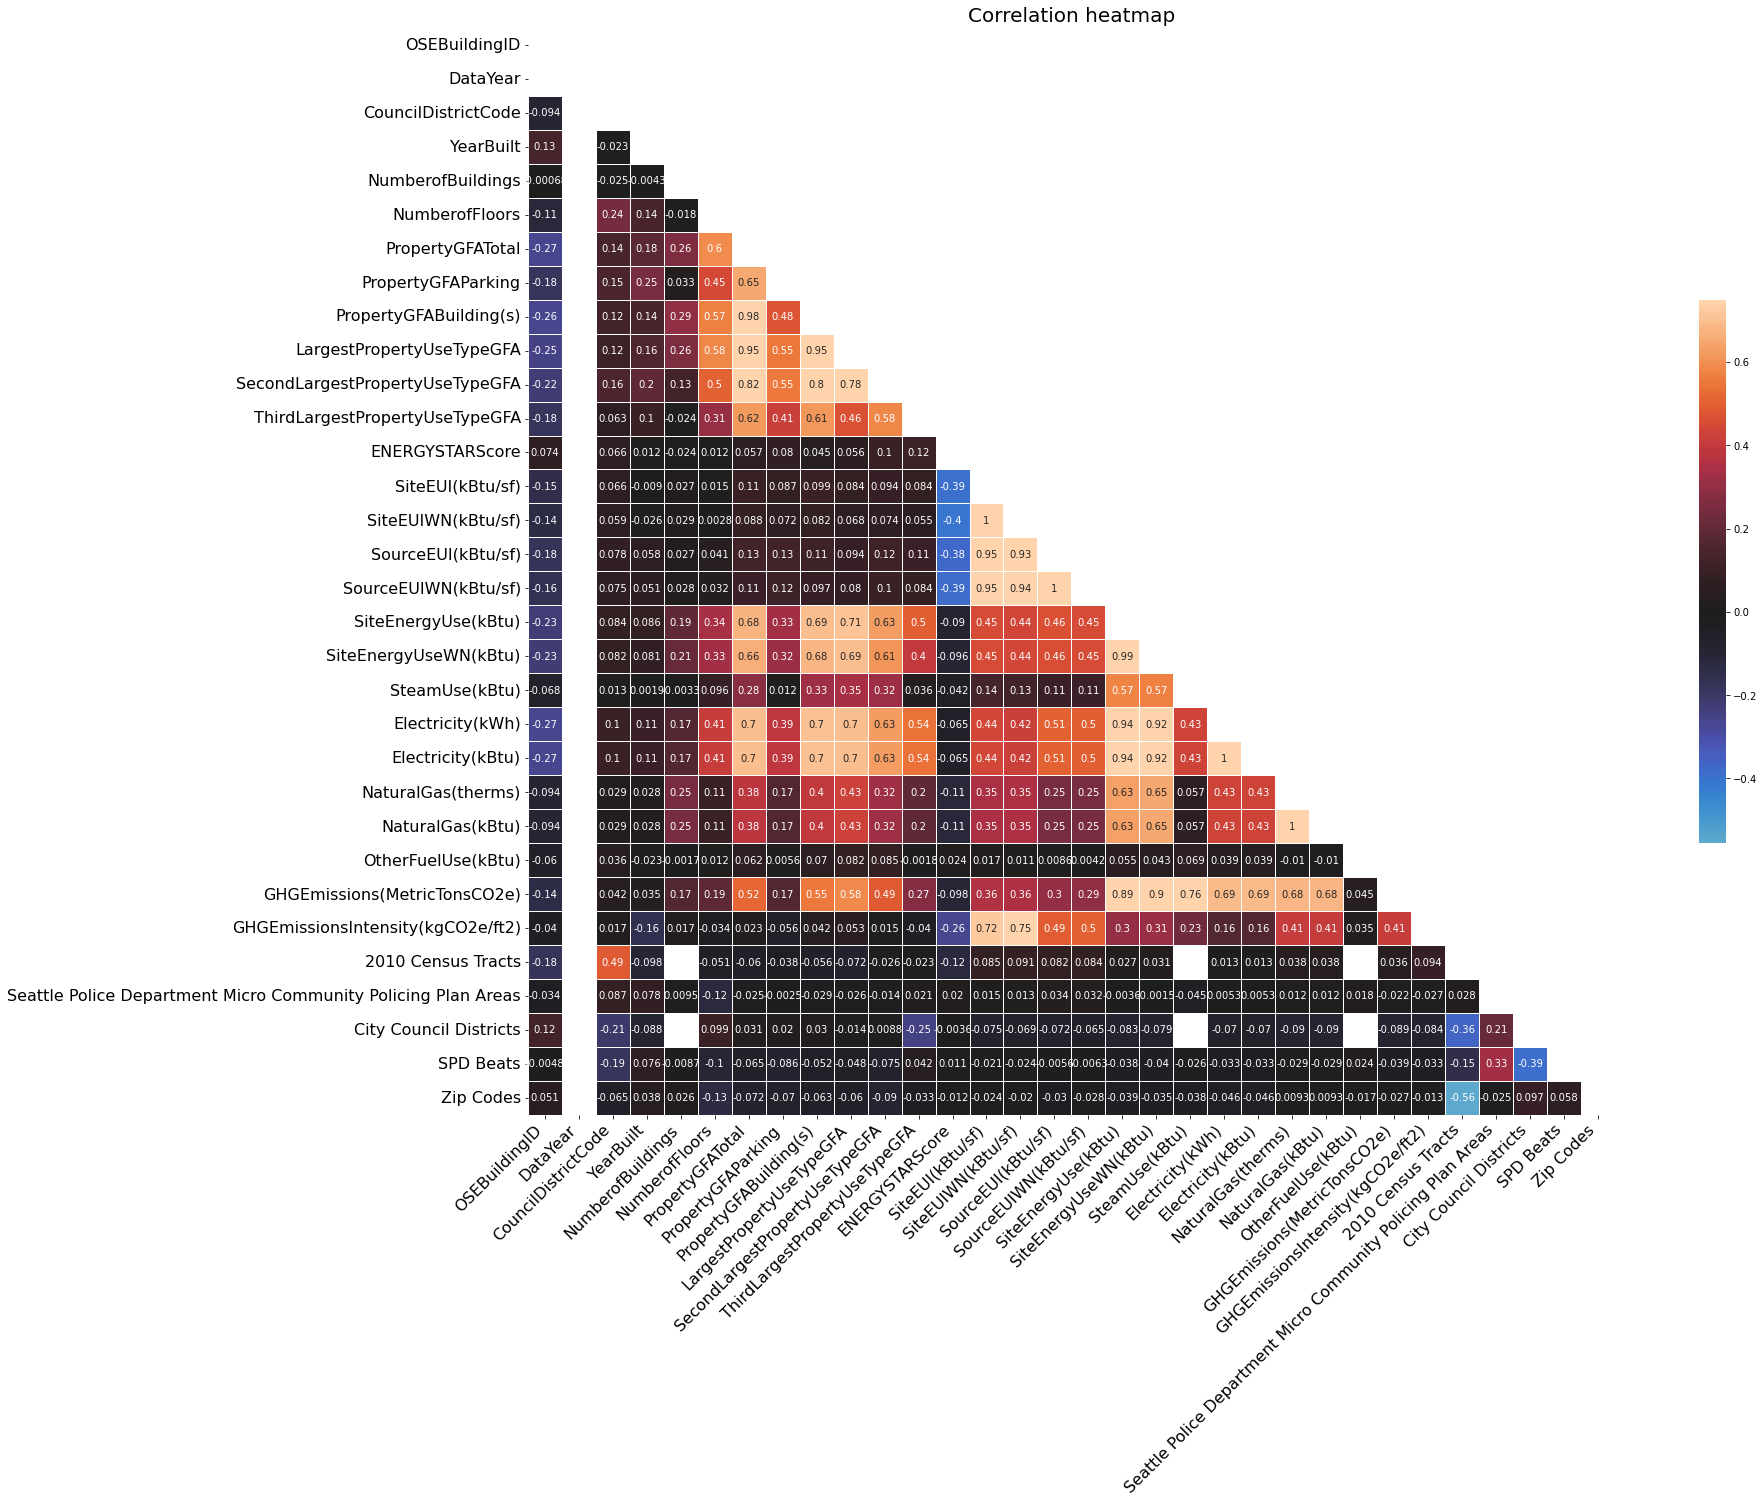

In [27]:
plt.figure(figsize=(30, 20))

correlation = data.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

In [28]:
categs = data.select_dtypes(include="object")

In [29]:
def categorize(feature):
    new_feature = feature.astype("category").cat.codes
    return new_feature

In [30]:
categs_to_nums = categs.apply(lambda col: categorize(col))

In [31]:
for col in categs_to_nums.columns:
    categs_to_nums.rename(columns={col: col + "_CATEG"}, inplace=True)

In [32]:
data_enhanced = data.join([categs_to_nums])

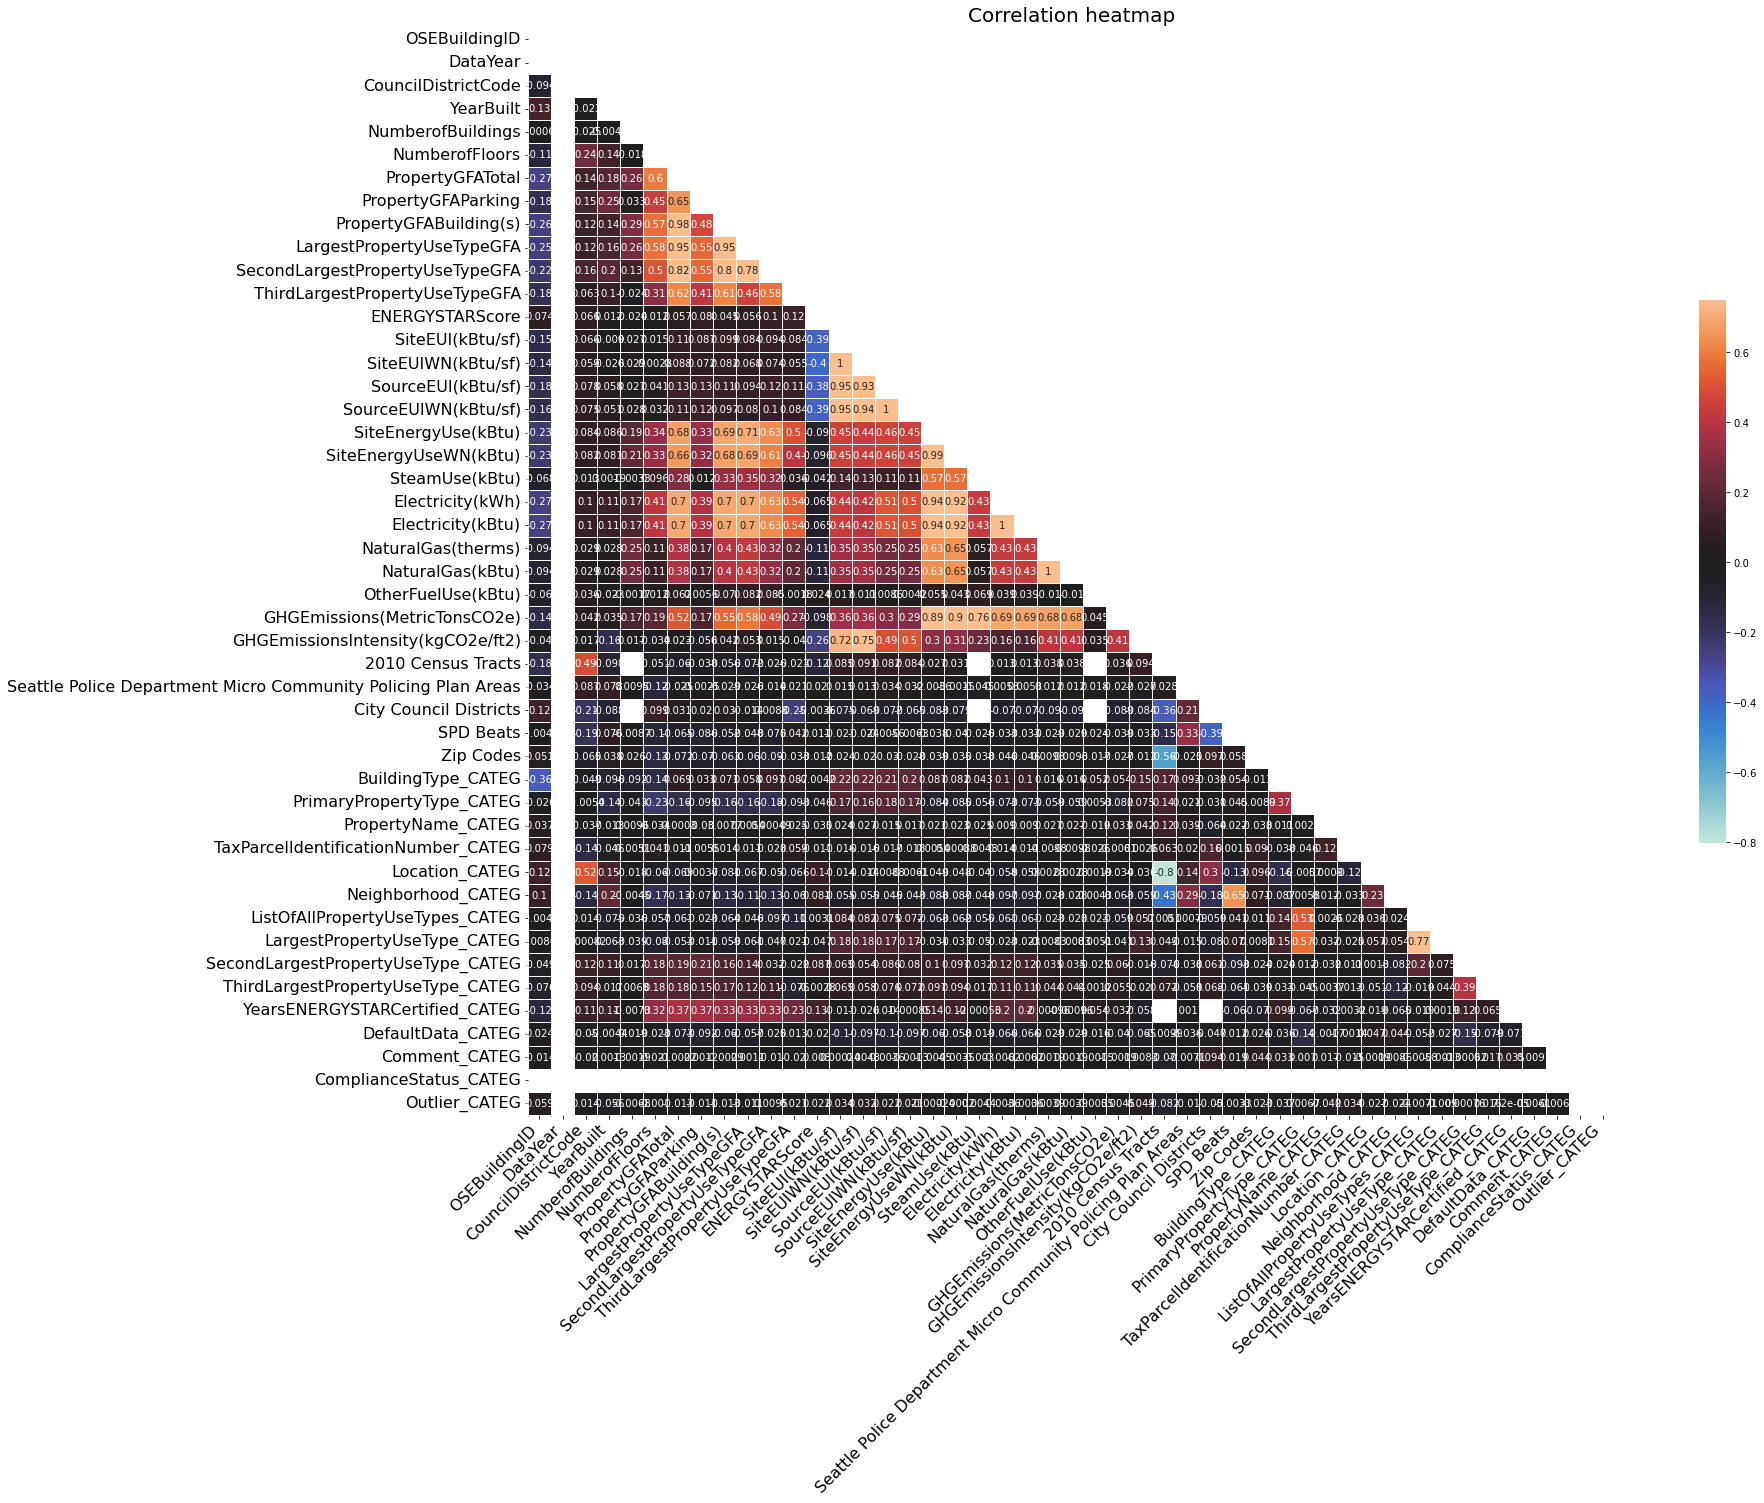

In [33]:
plt.figure(figsize=(30, 20))

correlation = data_enhanced.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

***
# 5 Saving

In [34]:
data.to_csv("data/2015-cleaned.csv", sep=",")

***
# 6 ...